In [1]:
# Python bibliotekos
import numpy as np                  # "numpy" yra biblioteka darbui su didelėmis, daugiamatėmis masyvų ir matricų kolekcijomis bei matematinėmis funkcijomis
import pandas as pd                 # "pandas" suteikia struktūras duomenims ir įrankius jų analizei, pvz., DataFrame
import matplotlib.pyplot as plt     # "matplotlib.pyplot" yra vizualizacijos biblioteka, leidžianti piešti įvairius grafikus
import warnings                     # "warnings" leidžia valdyti įspėjimus: juos ignoruoti, spausdinti, ar klaidinti
import requests                     # "requests" leidžia siųsti HTTP užklausas naudojant Python
from datetime import datetime       # "datetime" modulis suteikia funkcijas darbui su data ir laiku
from bs4 import BeautifulSoup       # "BeautifulSoup" padeda atlikti internetinių puslapių šaltinio kodo (HTML, XML) analizę ir duomenų surinkimą
import time                         # "time" modulis suteikia funkcijas, susijusias su laiku, pvz., laiko gaišimą ar laiko matavimą
import sqlite3                      # "sqlite3" leidžia dirbti su SQLite duomenų bazėmis, atliekant duomenų saugojimo, atnaujinimo ir gavimo operacijas
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppressing warnings
warnings.filterwarnings('ignore')   # Nustato, kad visi įspėjimai būtų ignoruojami

# Set up Selenium webdriver options
from selenium import webdriver                          # "selenium.webdriver" leidžia automatizuoti veiksmus interneto naršyklėje
from selenium.webdriver.chrome.options import Options   # "Options" leidžia nustatyti konfigūracijas Chrome naršyklės draiveriui

# Papildomai importuojame: 
from sklearn.linear_model import LinearRegression  # Tiesinės regresijos modelis
from sklearn.model_selection import train_test_split  # Duomenų padalijimas į treniravimo ir testavimo rinkinius
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
df2

In [166]:
# Modelis gyvunu ivykiui nuspeti 
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Nuskaitome .json faila ir paverciame i Dataframe 
with open("C:\\Users\\Pauliussl\\Paskaita70\\eismo_duomenys_2023.json" , 'r', encoding='utf-8') as file:
    data = json.load(file)
df = pd.DataFrame(data)

df2 = df[['eismoDalyviai', 'dalyviuSkaicius']]

df2

,eismoDalyviai,dalyviuSkaicius
0,"[{'dalyvisId': 48690423, 'kategorija': 'Kiti',...",2
1,"[{'dalyvisId': 48474937, 'kategorija': 'Automo...",2
2,"[{'dalyvisId': 48480520, 'kategorija': 'Automo...",2
3,"[{'dalyvisId': 48474443, 'kategorija': 'Automo...",1
4,"[{'dalyvisId': 48579303, 'kategorija': 'Automo...",2
...,...,...
24235,"[{'dalyvisId': 49086534, 'kategorija': 'Automo...",1
24236,"[{'dalyvisId': 49086564, 'kategorija': 'Automo...",1
24237,"[{'dalyvisId': 49094163, 'kategorija': 'Automo...",2
24238,"[{'dalyvisId': 49159858, 'kategorija': 'Automo...",2


In [ ]:
# Lyties pasiemimas 
lytis=[]
for i in df1['eismoDalyviai']:
    try:
        lytis.append(i[0]['lytis'])
    except:
        lytis.append(None)

In [153]:
# Esimo įvykių statistikos duomenys : https://data.gov.lt/datasets/509/ ; 
# Pritaikyti ML jog nustatytumėte, ar tai buvo susidūrimas su gyvūnu? 
# Ar galite nustatyti kaltininko lytį, pagal pateiktas eismo įvykio aplinkybes? 
# Hipotezė - vyrai daro daugiau vienos rūšies klaidų, moterys - kitos



# Modelis gyvunu ivykiui nuspeti 
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Nuskaitome .json faila ir paverciame i Dataframe 
with open("C:\\Users\\Pauliussl\\Paskaita70\\eismo_duomenys_2023.json" , 'r', encoding='utf-8') as file:
    data = json.load(file)
df = pd.DataFrame(data)

# Filtruojame reikalingus stulpelius ir prisidedame target stulpeli True/False 
df = df[['schema2', 'dangosRusis', 'dataLaikas', 'kelioGatvesKreive', 'dangosBukle', 'meteoSalygos', 'leistinasGreitis',  'neblaivusKaltininkai', 'apsvaigeKaltininkai', 'kelioApsvietimas',  'eismoDalyviai']]

df['targetas'] = df['schema2'].str.contains('gyv', case=False, na=False).astype(int)
df['kelioApsvietimas'] = df['kelioApsvietimas'].apply(lambda x: str(x) if isinstance(x, (list, dict)) else x)
df['dataLaikas'] = pd.to_datetime(df['dataLaikas'], format='%Y-%m-%d %H:%M', errors='coerce')
df['dataLaikas'] = df['dataLaikas'].dt.hour

def kalt_lytis(x):
    if x is not None:  
        for dalyvis in x:  
            if dalyvis.get('kaltininkas') == 'Taip':  
                return dalyvis.get('lytis')  
    return None  

df['lytis'] = df['eismoDalyviai'].apply(kalt_lytis)
# df = df.dropna()


encoder = LabelEncoder()
df['dangosRusis'] = encoder.fit_transform(df['dangosRusis'])
df['dangosBukle'] = encoder.fit_transform(df['dangosBukle'])
df['meteoSalygos'] = encoder.fit_transform(df['meteoSalygos'])
df['neblaivusKaltininkai'] = encoder.fit_transform(df['neblaivusKaltininkai'])
df['apsvaigeKaltininkai'] = encoder.fit_transform(df['apsvaigeKaltininkai'])
df['kelioApsvietimas'] = encoder.fit_transform(df['kelioApsvietimas'])
df['kelioGatvesKreive'] = encoder.fit_transform(df['kelioGatvesKreive'])
df['lytis'] = encoder.fit_transform(df['lytis'])

df2 = df[df['lytis'] != 0]

# # Modelio apmokymas: skeliame duomenis predictoriai/targetas
X = df.drop(columns=['schema2', 'targetas', 'eismoDalyviai'])
X.fillna(X.mean(), inplace=True)
X = X[X['lytis'] != 0]
y = df['targetas'].loc[X.index]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Logistic Regression model accuracy (in %):", acc*100)


Logistic Regression model accuracy (in %): 92.60200480022588


Stulpelių įtaka prognozėms:
                Feature  Importance
9                 lytis    6.009427
6  neblaivusKaltininkai    3.662699
8      kelioApsvietimas    0.654881
4          meteoSalygos    0.184482
2     kelioGatvesKreive    0.159806
0           dangosRusis    0.078938
5      leistinasGreitis    0.077852
3           dangosBukle    0.069002
7   apsvaigeKaltininkai    0.017985
1            dataLaikas    0.005978


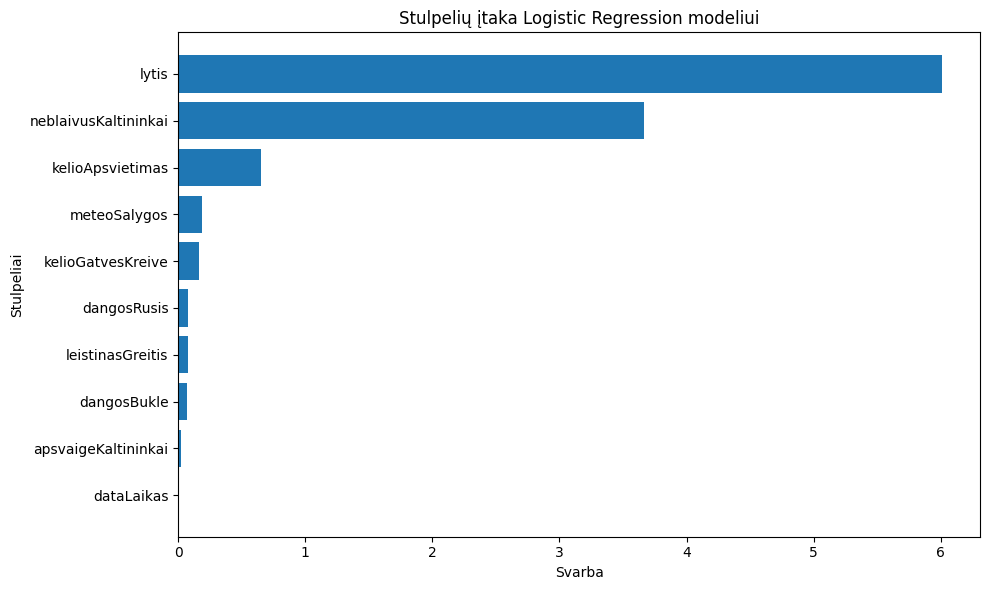

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ištraukiame modelio koeficientus
feature_importance = pd.DataFrame({
    'Feature': X.columns,                      # Stulpelių pavadinimai
    'Importance': np.abs(clf.coef_[0])         # Koeficientų absoliuti reikšmė
})

# Surikiuojame pagal svarbą
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Spausdiname lentelę
print("Stulpelių įtaka prognozėms:")
print(feature_importance)

# Grafinis vaizdavimas
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], align='center')
plt.xlabel('Svarba')
plt.ylabel('Stulpeliai')
plt.title('Stulpelių įtaka Logistic Regression modeliui')
plt.gca().invert_yaxis()  # Apverčiame ašį, kad svarbiausi stulpeliai būtų viršuje
plt.tight_layout()
plt.show()


<Axes: >

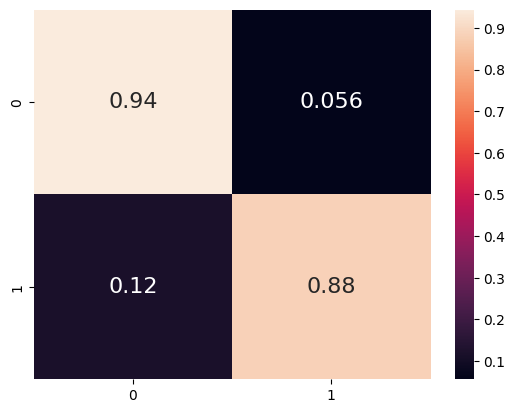

In [155]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(data=cm, annot=True, annot_kws={'fontsize':16})

In [156]:
# Modelis lyciai nuspeti 
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Nuskaitome .json faila ir paverciame i Dataframe 
with open("C:\\Users\\Pauliussl\\Paskaita70\\eismo_duomenys_2023.json" , 'r', encoding='utf-8') as file:
    data = json.load(file)
df = pd.DataFrame(data)

# Filtruojame reikalingus stulpelius ir prisidedame target stulpeli True/False 
df = df[['schema2', 'dangosRusis', 'dataLaikas', 'kelioGatvesKreive', 'dangosBukle', 'meteoSalygos', 'leistinasGreitis',  'neblaivusKaltininkai', 'apsvaigeKaltininkai', 'kelioApsvietimas',  'eismoDalyviai']]

df['kelioApsvietimas'] = df['kelioApsvietimas'].apply(lambda x: str(x) if isinstance(x, (list, dict)) else x)
df['dataLaikas'] = pd.to_datetime(df['dataLaikas'], format='%Y-%m-%d %H:%M', errors='coerce')
df['dataLaikas'] = df['dataLaikas'].dt.hour

def kalt_lytis(x):
    if x is not None:  
        for dalyvis in x:  
            if dalyvis.get('kaltininkas') == 'Taip':  
                if dalyvis.get('lytis')  == 'Vyras':
                    return 1
                else:
                    return 0                                    # Vyras - 1, Moteris 0
    return None  

df['lytis'] = df['eismoDalyviai'].apply(kalt_lytis)
# df = df.dropna()

encoder = LabelEncoder()
df['dangosRusis'] = encoder.fit_transform(df['dangosRusis'])
df['dangosBukle'] = encoder.fit_transform(df['dangosBukle'])
df['meteoSalygos'] = encoder.fit_transform(df['meteoSalygos'])
df['neblaivusKaltininkai'] = encoder.fit_transform(df['neblaivusKaltininkai'])
df['apsvaigeKaltininkai'] = encoder.fit_transform(df['apsvaigeKaltininkai'])
df['kelioApsvietimas'] = encoder.fit_transform(df['kelioApsvietimas'])
df['kelioGatvesKreive'] = encoder.fit_transform(df['kelioGatvesKreive'])

df2 = df[df['lytis'] != None]

# # Modelio apmokymas: skeliame duomenis predictoriai/targetas
X = df.drop(columns=['schema2', 'eismoDalyviai', 'lytis'])  # Pašaliname nereikalingus stulpelius
X.fillna(X.mean(), inplace=True)    # Užpildome trūkstamas reikšmes vidurkiu

y = df['lytis'].loc[X.index]        # Užtikriname, kad y turi tuos pačius indeksus kaip X

X = X[~y.isna()]                    # Tik tos eilutės, kur y nėra NaN
y = y.dropna()                      # Pašaliname NaN iš y


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Logistic Regression model accuracy (in %):", acc*100)

Logistic Regression model accuracy (in %): 63.3054892601432


Stulpelių įtaka prognozėms:
                Feature  Importance
6  neblaivusKaltininkai    1.831859
8      kelioApsvietimas    0.119672
2     kelioGatvesKreive    0.111857
7   apsvaigeKaltininkai    0.060019
3           dangosBukle    0.025721
0           dangosRusis    0.023805
5      leistinasGreitis    0.018442
4          meteoSalygos    0.009516
1            dataLaikas    0.003856


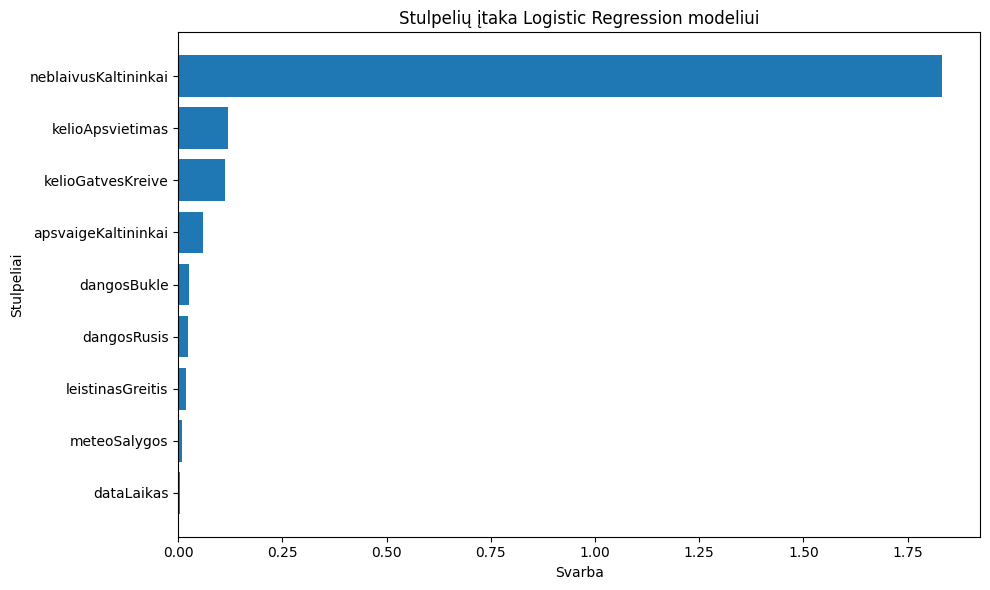

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ištraukiame modelio koeficientus
feature_importance = pd.DataFrame({
    'Feature': X.columns,                      # Stulpelių pavadinimai
    'Importance': np.abs(clf.coef_[0])         # Koeficientų absoliuti reikšmė
})

# Surikiuojame pagal svarbą
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Spausdiname lentelę
print("Stulpelių įtaka prognozėms:")
print(feature_importance)

# Grafinis vaizdavimas
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], align='center')
plt.xlabel('Svarba')
plt.ylabel('Stulpeliai')
plt.title('Stulpelių įtaka Logistic Regression modeliui')
plt.gca().invert_yaxis()  # Apverčiame ašį, kad svarbiausi stulpeliai būtų viršuje
plt.tight_layout()
plt.show()


<Axes: >

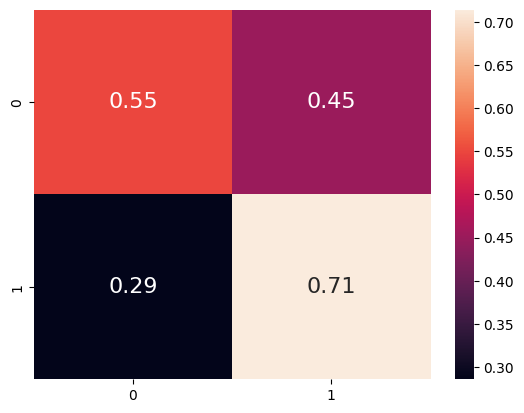

In [158]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(data=cm, annot=True, annot_kws={'fontsize':16})

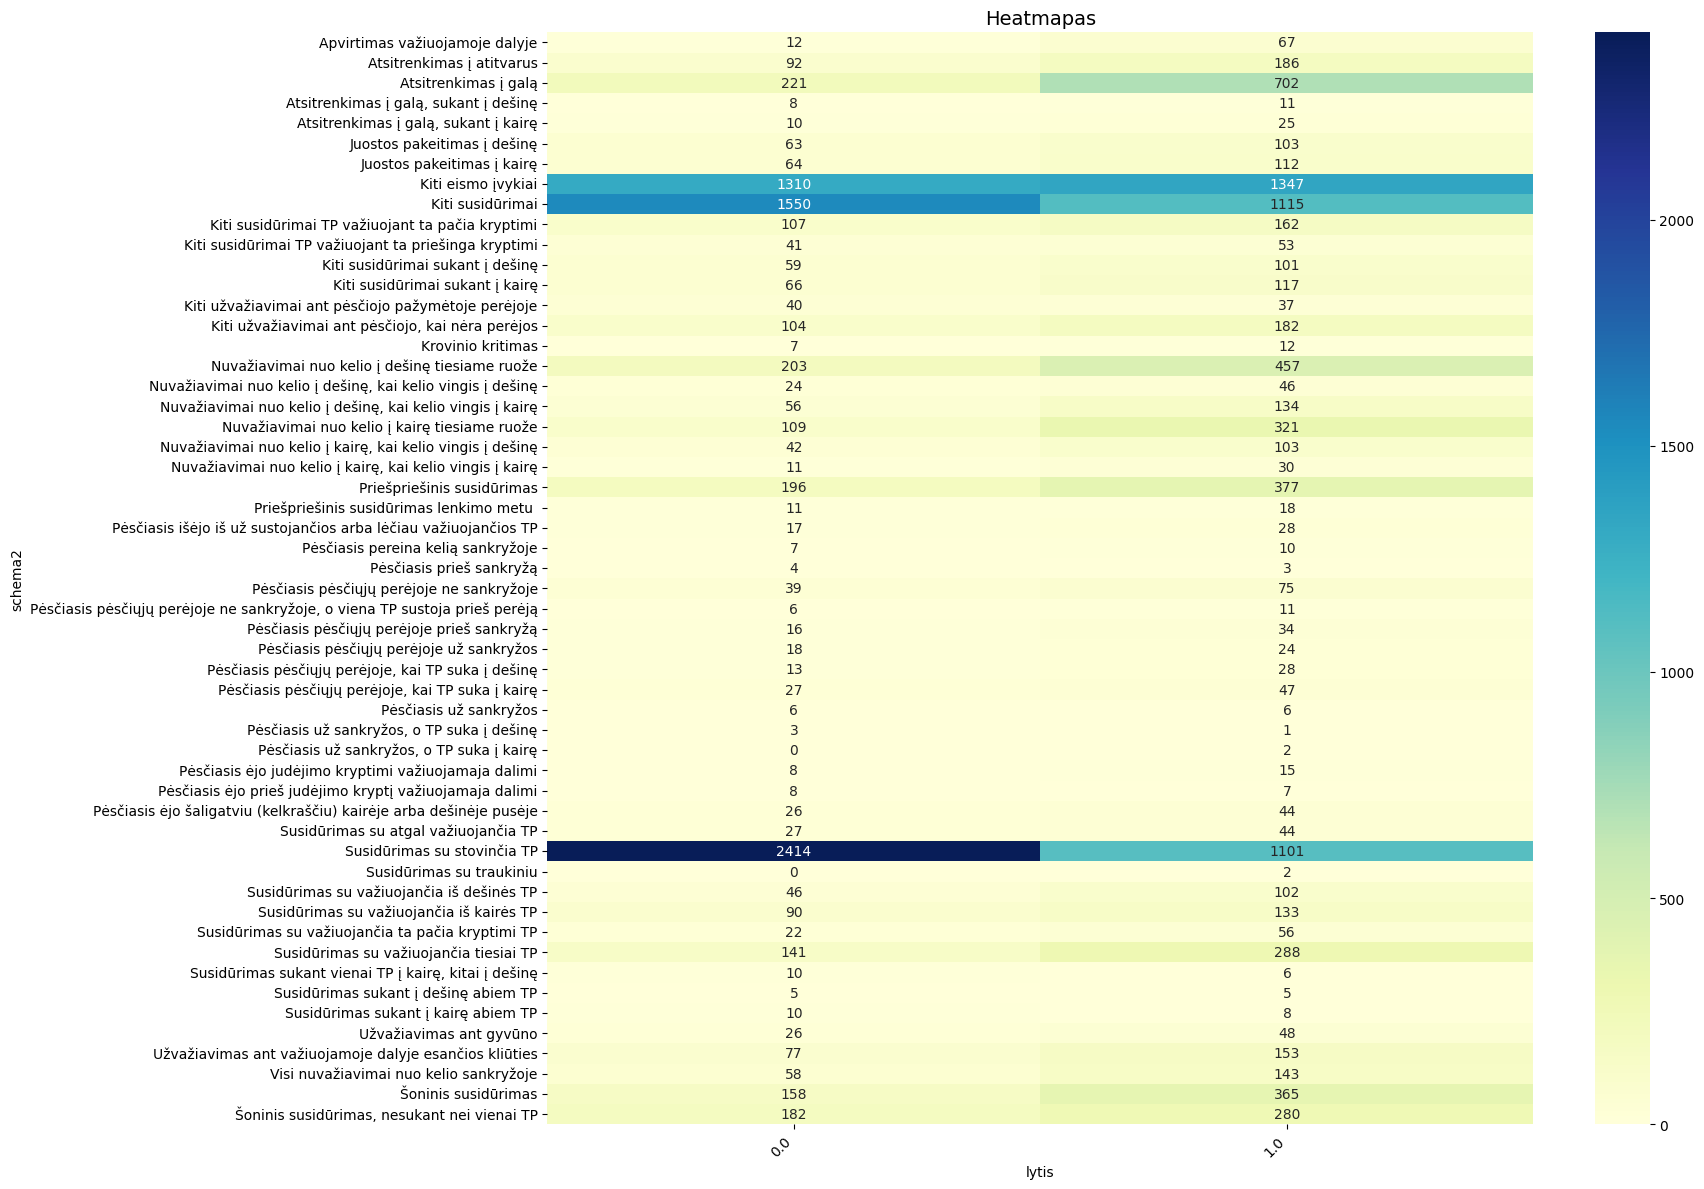

In [ ]:
#Heatmapas 
def extract_lytis_schema(df2):
    schema_lytis_counts = df2.groupby(['schema2', 'lytis']).size().unstack(fill_value=0)
    return schema_lytis_counts

# Gautas duomenis grupuojame pagal 'schema2' ir 'lytis'
lytis_schema_stats = extract_lytis_schema(df2)


plt.figure(figsize=(18, 12))
sns.heatmap(lytis_schema_stats, annot=True, fmt="d", cmap="YlGnBu")

plt.title('Heatmapas', fontsize=14)
# plt.xlabel('Lytis (0 - Vyras, 1 - Moteris)', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

